In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import copy

import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import blo.params as blo_params
from blo.utils import load_problem, factory_get_path

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.reload_library()
plt.style.use(['science'])

In [4]:
def get_solver_results(n_vals, k_ratios, data_dir):
    """ Get results for the solver. """
    solver_result_dir = 'solver_results'
    solver_result_dir = f'{data_dir}{solver_result_dir}/'

    solver_result_files = os.listdir(solver_result_dir)
    solver_result_files = list(filter(lambda x: "raw_res" not in x, solver_result_files))

    print(len(solver_result_files))
    solver_results = {}

    for n in n_vals:
        solver_results [n] = {}

        for k_ratio in k_ratios:
            k = int(np.ceil(n * k_ratio))
            solver_results[n][k] = []

            for inst_id in inst_ids[n]:

                f = list(filter(lambda x: f'n-{n}_k-{k}_i-{inst_id}_' in x, solver_result_files))[0]
                f = solver_result_dir + f
                with open(f, 'rb') as p:
                    solver_results[n][k].append(pkl.load(p))

    return solver_results

In [5]:
def get_isnn_results(n_vals, k_ratios, data_dir):
    """ Get results for the solver. """
    baseline_result_dir = 'isnn_results'
    baseline_result_dir = f'{data_dir}{baseline_result_dir}/'

    baseline_result_files = os.listdir(baseline_result_dir)

    print(len(baseline_result_files))
    baseline_results = {}

    for n in n_vals:
        baseline_results[n] = {}

        for k_ratio in k_ratios:
            k = int(np.ceil(n * k_ratio))
            baseline_results[n][k] = []

            for inst_id in inst_ids[n]:

                if n == 100:
                    baseline_results[n][k].append(np.nan)
                    continue
                    
                f = list(filter(lambda x: f'n-{n}_k-{k}_i-{inst_id}' in x, baseline_result_files))[0]
                f = baseline_result_dir + f
                with open(f, 'rb') as p:
                    baseline_results[n][k].append(pkl.load(p))

    return baseline_results

In [6]:
def get_results(n_vals, k_ratios, data_dir, model_type, vf_constr_type, approx_type):
    """ Get results for ml/greedy algorithm. """
    result_dir = 'results'
    result_dir = f'{data_dir}{result_dir}/'

    result_files = os.listdir(result_dir)
    result_files = list(filter(lambda x: f"m-{model_type}" in x, result_files))
    result_files = list(filter(lambda x: f"v-{vf_constr_type}" in x, result_files))
    result_files = list(filter(lambda x: f"a-{approx_type}" in x, result_files))

    results = {}

    for n in n_vals:
        results [n] = {}

        for k_ratio in k_ratios:
            k = int(np.ceil(n * k_ratio))
            results[n][k] = []

            for inst_id in inst_ids[n]:
                # try:
                f = list(filter(lambda x: f'n-{n}_k-{k}_i-{inst_id}_' in x, result_files))[0]
                f = result_dir + f
                
                with open(f, 'rb') as p:
                    results[n][k].append(pkl.load(p))
    
    return results


In [7]:
def get_time_to_obj(algo_obj, algo_time, solver_result, as_ratio=True):
    """ Gets time to a given objective. """
    inc_objs = solver_result['inc_objs']
    inc_times = solver_result['inc_times']

    if np.isnan(algo_obj):
        return np.nan

    # iterate over incumbents
    time_to_obj = None
    for i in range(len(inc_objs)):
        if inc_objs[i] <= algo_obj + 1e-5:
            time_to_obj = inc_times[i]
            break

    # check the final objective
    if time_to_obj is None:
        if solver_result['follower_obj'] <= algo_obj + 1e-5:
            time_to_obj = solver_result['time']
        else:
            time_to_obj = np.nan

    # cast to ratio if specified
    if as_ratio:
        time_to_obj = time_to_obj / algo_time 

    return time_to_obj

In [8]:
def get_obj_at_ml_time(algo_obj, algo_time, solver_result, as_re=True):
    """ Gets objective at time of given algorithm. """
    inc_objs = solver_result['inc_objs']
    inc_times = solver_result['inc_times']
            
    if np.isnan(solver_result['leader_obj']):
        return np.nan

    if solver_result['time'] < algo_time:
        return solver_result['leader_obj']
    
    # iterate over incumbents
    best_inc = np.nan
    for i in range(len(inc_objs)):
        if inc_times[i] <= algo_time:
            best_inc = inc_objs[i]

    # compute relative err
    if as_re:
        best_obj = np.min([best_inc, algo_obj])
        relative_err = 100 * (best_inc - best_obj) / best_obj
        return relative_err
    
    return best_inc

In [9]:
def get_time_to_str(algo_time_to, precision=2):
    """ Get time to for latex tables.  """
    algo_worse = len(algo_time_to) - np.count_nonzero(np.isnan(algo_time_to))
    if algo_worse == 0:
        algo_mean_tt = np.nan
    else:
        algo_mean_tt = round(np.nanmean(algo_time_to), precision)

    algo_str = f"{algo_mean_tt}  ({algo_worse})"

    return algo_str

In [10]:
model_type = "inst_encoder"

n_vals = [18, 20, 22, 25, 28, 30, 100]
k_ratios = [1/4, 1/2, 3/4]

inst_ids = {
    18 : list(range(1,11)),
    20 : list(range(1,11)),
    22 : list(range(1,11)),
    25 : list(range(1,11)),
    28 : list(range(1,11)),
    30 : list(range(1,11)), 
    100 : list(range(1,101)),
}

In [11]:
problem = 'kp'
data_dir = f'../data/{problem}/'

In [12]:
solver_results = get_solver_results(n_vals, k_ratios, data_dir)

480


In [13]:
greedy_results = get_results(n_vals, k_ratios, data_dir, "greedy", "none", "lower")

In [14]:
nn_slack_results = get_results(n_vals, k_ratios, data_dir, model_type, "slack", "lower")

In [15]:
nn_dampening_results = get_results(n_vals, k_ratios, data_dir, model_type, "dampening", "lower")

In [16]:
nn_none_results = get_results(n_vals, k_ratios, data_dir, model_type, "none", "lower")

In [17]:
nn_upper_results = get_results(n_vals, k_ratios, data_dir, model_type, "none", "upper")

In [18]:
isnn_results = get_isnn_results(n_vals, k_ratios, data_dir)

180


# Main Paper Results

In [19]:
# columns for table
cols = ['nn_l_obj', 'nn_u_obj', 'g_obj', 's_obj',
        'nn_l_mre', 'nn_u_mre', 'g_mre', 's_mre',
        'nn_l_time', 'nn_u_time', 'g_time', 's_time', 
        'nn_l_to', 'nn_u_to', 'g_to', 
        'nn_l_at', 'nn_u_at', 'g_at', 
       ]

In [20]:
# indicies for table
indicies = []
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        id = f"{n} & {k}"
        # indicies.append((n,k))
        indicies.append(id)


avg = "\\multicolumn{2}{c|}{Average \\cite{tang2016class}}"
avg_100 = "\\multicolumn{2}{c|}{Average $n=100$}"
indicies.append(avg)
indicies.append(avg_100)

In [21]:
# more in depth gap storing
relative_errors = {
    'nn_l' : {},
    'nn_u': {},
    'greedy' : {},
    'exact' : {},
 }


for k_ratio in k_ratios:
    relative_errors['nn_l'][k_ratio] = {}
    relative_errors['nn_u'][k_ratio] = {}
    relative_errors['greedy'][k_ratio] = {}
    relative_errors['exact'][k_ratio] = {}

    # for n in n_vals:
    #     relative_errors['nn_l'][k_ratio][n] = []
    #     relative_errors['nn_u'][k_ratio][n] = []
    #     relative_errors['greedy'][k_ratio][n] = []
    #     relative_errors['exact'][k_ratio][n] = []

In [22]:
df = pd.DataFrame(index=indicies, columns=cols)

In [23]:
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        
        # results for solver
        solver_res = solver_results[n][k]
        solver_times = list(map(lambda x: x['time'], solver_res))
        solver_objs = list(map(lambda x: x['follower_obj'], solver_res))

        # results for greedy
        greedy_res = greedy_results[n][k]
        greedy_times = list(map(lambda x: x['time'], greedy_res))
        greedy_objs = list(map(lambda x: x['obj'], greedy_res))

        # results for nn-l
        nn_slack_res = nn_slack_results[n][k]
        nn_slack_times = list(map(lambda x: x['time'], nn_slack_res))
        nn_slack_objs = list(map(lambda x: x['follower_obj'], nn_slack_res))
        
        # results for nn-u
        nn_upper_res = nn_upper_results[n][k]
        nn_upper_times = list(map(lambda x: x['time'], nn_upper_res))
        nn_upper_objs = list(map(lambda x: x['follower_obj'], nn_upper_res))

        # get time to results
        as_ratio = True
        greedy_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), greedy_objs, greedy_times, solver_res))
        nn_slack_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), nn_slack_objs, nn_slack_times, solver_res))
        nn_upper_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), nn_upper_objs, nn_upper_times, solver_res))

        # get obj at time
        as_re= True
        solver_at_nn_slack_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), nn_slack_objs, nn_slack_times, solver_res))
        solver_at_nn_upper_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), nn_upper_objs, nn_upper_times, solver_res))
        solver_at_greedy_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), greedy_objs, greedy_times, solver_res))

        # best best known obj for each instance
        objs = np.array([solver_objs, greedy_objs, nn_slack_objs, nn_upper_objs])
        best_objs = list(np.min(objs, axis=0))

        # compute relative errors
        solver_re = list(map(lambda x, y: 100 * (x-y)/y, solver_objs, best_objs)) 
        greedy_re = list(map(lambda x, y: 100 * (x-y)/y, greedy_objs, best_objs)) 
        nn_slack_re = list(map(lambda x, y: 100 * (x-y)/y, nn_slack_objs, best_objs)) 
        nn_upper_re = list(map(lambda x, y: 100 * (x-y)/y, nn_upper_objs, best_objs)) 


        #id = (n,k)
        id = f"{n} & {k}"
        
        # add results to dataframe
        df['nn_l_obj'][id] = np.mean(nn_slack_objs)
        df['nn_u_obj'][id] = np.mean(nn_upper_objs)
        df['g_obj'][id] = np.mean(greedy_objs)
        df['s_obj'][id] = np.mean(solver_objs)

        df['nn_l_mre'][id] = np.mean(nn_slack_re)
        df['nn_u_mre'][id] = np.mean(nn_upper_re)
        df['g_mre'][id] = np.mean(greedy_re)
        df['s_mre'][id] = np.mean(solver_re)
        
        df['nn_l_time'][id] = np.mean(nn_slack_times)
        df['nn_u_time'][id] = np.mean(nn_upper_times)
        df['g_time'][id] = np.mean(greedy_times)
        df['s_time'][id] = np.mean(solver_times)

        df['nn_l_to'][id] = get_time_to_str(nn_slack_time_to)
        df['nn_u_to'][id] = get_time_to_str(nn_upper_time_to)
        df['g_to'][id] = get_time_to_str(greedy_time_to)

        df['nn_l_at'][id] = get_time_to_str(solver_at_nn_slack_time)
        df['nn_u_at'][id] = get_time_to_str(solver_at_nn_upper_time)
        df['g_at'][id] = get_time_to_str(solver_at_greedy_time)

        relative_errors['nn_l'][k_ratio][n] = nn_slack_re
        relative_errors['nn_u'][k_ratio][n] = nn_upper_re
        relative_errors['greedy'][k_ratio][n] = greedy_re
        relative_errors['exact'][k_ratio][n] = solver_re

In [24]:
nn_l_time = []
nn_u_time = []
greedy_time = []
solver_time = []

nn_l_mre = []
nn_u_mre = []
greedy_mre = []
solver_mre = []


nn_l_time_100= []
nn_u_time_100 = []
greedy_time_100 = []
solver_time_100 = []

nn_l_mre_100 = []
nn_u_mre_100 = []
greedy_mre_100 = []
solver_mre_100 = []

for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        
        solver_res = solver_results[n][k]
        solver_times = list(map(lambda x: x['time'], solver_res))
        solver_objs = list(map(lambda x: x['follower_obj'], solver_res))

        # results for greedy
        greedy_res = greedy_results[n][k]
        greedy_times = list(map(lambda x: x['time'], greedy_res))
        greedy_objs = list(map(lambda x: x['obj'], greedy_res))

        # results for nn-l
        nn_slack_res = nn_slack_results[n][k]
        nn_slack_times = list(map(lambda x: x['time'], nn_slack_res))
        nn_slack_objs = list(map(lambda x: x['follower_obj'], nn_slack_res))
        
        # results for nn-u
        nn_upper_res = nn_upper_results[n][k]
        nn_upper_times = list(map(lambda x: x['time'], nn_upper_res))
        nn_upper_objs = list(map(lambda x: x['follower_obj'], nn_upper_res))

        # best best known obj for each instance
        objs = np.array([solver_objs, greedy_objs, nn_slack_objs, nn_upper_objs])
        best_objs = list(np.min(objs, axis=0))

        # compute relative errors
        solver_re = list(map(lambda x, y: 100 * (x-y)/y, solver_objs, best_objs)) 
        greedy_re = list(map(lambda x, y: 100 * (x-y)/y, greedy_objs, best_objs)) 
        nn_slack_re = list(map(lambda x, y: 100 * (x-y)/y, nn_slack_objs, best_objs)) 
        nn_upper_re = list(map(lambda x, y: 100 * (x-y)/y, nn_upper_objs, best_objs)) 

        if n < 100:
            nn_l_time += nn_slack_times
            nn_u_time += nn_upper_times
            greedy_time += greedy_times
            solver_time += solver_times
            
            nn_l_mre += nn_slack_re
            nn_u_mre += nn_upper_re
            greedy_mre += greedy_re
            solver_mre += solver_re

        else:
            nn_l_time_100 += nn_slack_times
            nn_u_time_100 += nn_upper_times
            greedy_time_100 += greedy_times
            solver_time_100 += solver_times
            
            nn_l_mre_100 += nn_slack_re
            nn_u_mre_100 += nn_upper_re
            greedy_mre_100 += greedy_re
            solver_mre_100 += solver_re


In [25]:
# compute mean
df['nn_l_mre'][avg] = np.mean(nn_l_mre)
df['nn_u_mre'][avg] = np.mean(nn_u_mre)
df['g_mre'][avg] = np.mean(greedy_mre)
df['s_mre'][avg] = np.mean(solver_mre)

df['nn_l_time'][avg] = np.mean(nn_l_time)
df['nn_u_time'][avg] = np.mean(nn_u_time)
df['g_time'][avg] = np.mean(greedy_time)
df['s_time'][avg] = np.mean(solver_time)

df['nn_l_mre'][avg_100] = np.mean(nn_l_mre_100)
df['nn_u_mre'][avg_100] = np.mean(nn_u_mre_100)
df['g_mre'][avg_100] = np.mean(greedy_mre_100)
df['s_mre'][avg_100] = np.mean(solver_mre_100)

df['nn_l_time'][avg_100] = np.mean(nn_l_time_100)
df['nn_u_time'][avg_100] = np.mean(nn_u_time_100)
df['g_time'][avg_100] = np.mean(greedy_time_100)
df['s_time'][avg_100] = np.mean(solver_time_100)

In [26]:
def latex_results_main_paper(df_):
    """ Generate Latex table for results.  """
    df = df_.copy()

    df = df.drop('nn_l_obj', axis=1)
    df = df.drop('nn_u_obj', axis=1)
    df = df.drop('g_obj', axis=1)
    df = df.drop('s_obj', axis=1)
    
    df = df.drop('nn_l_to', axis=1)
    df = df.drop('nn_u_to', axis=1)
    df = df.drop('g_to', axis=1)

    df = df.drop('nn_l_at', axis=1)
    df = df.drop('nn_u_at', axis=1)
    df = df.drop('g_at', axis=1)

    col_order = [
        'nn_l_mre', 'nn_l_time',
        'nn_u_mre', 'nn_u_time', 
        'g_mre', 'g_time', 
        's_mre', 's_time',
    ]

    df = df[col_order]

    df = df.rename(columns={
        'nn_l_mre' : 'MRE',
        'nn_u_mre' : 'MRE\ ',
        'g_mre'    : 'MRE\ \ ',
        's_mre'    : 'MRE\ \ \ ',

        'nn_l_time' : 'Time',
        'nn_u_time' : 'Time\ ',
        'g_time'    : 'Time\ \ ',
        's_time'    : 'Time\ \ \ ',
        
    })

    df = df.style.format(thousands=',', precision=2)        

    # bold minimum value in table
    df = df.highlight_min(subset=['MRE',  'MRE\ ',  'MRE\ \ ',  'MRE\ \ \ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['Time', 'Time\ ', 'Time\ \ ', 'Time\ \ \ '], props='textbf:--rwrap;', axis=1)
    
    # caption
    end_str = '}\n\\caption{Knapsack Results:'
    end_str += 'Each row averaged over 10 instances, except for $n=100$, which is average over 100 instances.  ' 
    end_str += '\\mls{} and \\mlu{} specify the lower- and upper-level approximations respectively.  '
    end_str += 'All times in seconds.  }\n'
    end_str += '\\label{tab:kp_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='cc|rr|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')
    
    latex_str2 = (latex_str.splitlines())
    row_id = "$n$ & $k$"
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{2}{c|}{\\mls}  & \multicolumn{2}{c|}{\\mlu} & \multicolumn{2}{c}{\\greedy} & \multicolumn{2}{c}{\\solver} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.6\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [27]:
latex_results_main_paper(df)

\begin{table*}[h]\centering\resizebox{0.6\textwidth}{!}{
\begin{tabular}{cc|rr|rr|rr|rr}
\toprule
$n$ & $k$ & \multicolumn{2}{c|}{\mls}  & \multicolumn{2}{c|}{\mlu} & \multicolumn{2}{c}{\greedy} & \multicolumn{2}{c}{\solver} \\
 & MRE & Time & MRE\  & Time\  & MRE\ \  & Time\ \  & MRE\ \ \  & Time\ \ \  \\
\midrule
18 & 5 & 1.48 & 0.59 & 1.48 & 0.34 & 1.82 & \textbf{0.14} & \textbf{0.00} & 9.55 \\
18 & 9 & 1.51 & 0.59 & 1.51 & 0.43 & 3.97 & \textbf{0.22} & \textbf{0.00} & 5.81 \\
18 & 14 & \textbf{0.00} & 0.22 & \textbf{0.00} & 0.17 & 64.22 & \textbf{0.03} & \textbf{0.00} & 0.39 \\
20 & 5 & 0.41 & 0.62 & 0.41 & 0.45 & 2.19 & \textbf{0.25} & \textbf{0.00} & 23.18 \\
20 & 10 & 0.99 & 0.66 & 0.99 & 0.58 & 0.99 & \textbf{0.36} & \textbf{0.00} & 10.27 \\
20 & 15 & 3.57 & 0.32 & 3.57 & 0.19 & 23.39 & \textbf{0.02} & \textbf{0.00} & 0.94 \\
22 & 6 & 0.71 & 0.19 & 0.71 & \textbf{0.18} & 0.42 & 0.18 & \textbf{0.00} & 42.30 \\
22 & 11 & 1.01 & 0.28 & 1.01 & \textbf{0.28} & 1.08 & 0.33 & \textbf{

# Appendix Objective

In [28]:
def latex_results_appendix_obj_paper(df_):
    """ Generate Latex table for results.  """
    df = df_.copy()

    df = df.rename(columns={
        'nn_l_obj' : '\\mls',
        'nn_u_obj' : '\\mlu',
        'g_obj' : '\\greedy',
        's_obj' : '\\solver',
 
        'nn_l_mre' : '\\mls\ ',
        'nn_u_mre' : '\\mlu\ ',
        'g_mre' : '\\greedy\ ',
        's_mre' : '\\solver\ ',

        'nn_l_time' : '\\mls\ \ ',
        'nn_u_time' : '\\mlu\ \ ',
        'g_time' : '\\greedy\ \ ',
        's_time' : '\\solver\ \ ',

        'nn_l_to' : '\\mls\ \ \ ',
        'nn_u_to' : '\\mlu\ \ \ ',
        'g_to' : '\\greedy\ \ \ ',

        'nn_l_at' : '\\mls\ \ \ \ ',
        'nn_u_at' : '\\mlu\ \ \ \ ',
        'g_at' : '\\greedy\ \ \ \ ',
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_min(subset=['\\mls',     '\\mlu',     '\\greedy',    '\\solver'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls\ ',   '\\mlu\ ',   '\\greedy\ ',  '\\solver\ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls\ \ ', '\\mlu\ \ ', '\\greedy\ \ ', '\\solver\ \ '], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{Knapsack Results:'
    end_str += 'Each row averaged over 10 instances, except for $n=100$, which is average over 100 instances.  ' 
    end_str += '\\mls{} and \\mlu{} specify the lower- and upper-level approximations respectively.  '
    end_str += 'All times in seconds.  }\n'
    end_str += '\\label{tab:kp_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='l|rrrr|rrrr|rrrr|rrr|rrr').replace('_','\_').replace('nan', '-').replace('#', '\#')
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, '($n$,$k$) & \multicolumn{4}{c|}{Objective}  &  \multicolumn{4}{c|}{Mean Relative Error (\%)}  & \multicolumn{4}{c|}{Solving Time} & \multicolumn{3}{c|}{Solver Time Ratio} & \multicolumn{3}{c}{Solver Relative Error at Time}\\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{1.0\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [29]:
latex_results_appendix_obj_paper(df)

\begin{table*}[h]\centering\resizebox{1.0\textwidth}{!}{
\begin{tabular}{l|rrrr|rrrr|rrrr|rrr|rrr}
\toprule
($n$,$k$) & \multicolumn{4}{c|}{Objective}  &  \multicolumn{4}{c|}{Mean Relative Error (\%)}  & \multicolumn{4}{c|}{Solving Time} & \multicolumn{3}{c|}{Solver Time Ratio} & \multicolumn{3}{c}{Solver Relative Error at Time}\\
 & \mls & \mlu & \greedy & \solver & \mls\  & \mlu\  & \greedy\  & \solver\  & \mls\ \  & \mlu\ \  & \greedy\ \  & \solver\ \  & \mls\ \ \  & \mlu\ \ \  & \greedy\ \ \  & \mls\ \ \ \  & \mlu\ \ \ \  & \greedy\ \ \ \  \\
\midrule
18 & 5 & 308.30 & 308.30 & 309.20 & \textbf{303.50} & 1.48 & 1.48 & 1.82 & \textbf{0.00} & 0.59 & 0.34 & \textbf{0.14} & 9.55 & 24.48  (10) & 35.86  (10) & 177.39  (10) & -  (0) & -  (0) & -  (0) \\
18 & 9 & 145.60 & 145.60 & 149.10 & \textbf{143.40} & 1.51 & 1.51 & 3.97 & \textbf{0.00} & 0.59 & 0.43 & \textbf{0.22} & 5.81 & 12.31  (10) & 18.52  (10) & 73.49  (10) & -  (0) & -  (0) & -  (0) \\
18 & 14 & \textbf{31.00} & \textbf{31.00}

# Appendix Boxplots

In [30]:
def plot_for_k_ratio(relative_errors, k_ratio):
    re = copy.deepcopy(relative_errors)
    re['nn_l'][k_ratio] = list(re['nn_l'][k_ratio].values())
    re['nn_u'][k_ratio] = list(re['nn_u'][k_ratio].values())
    re['greedy'][k_ratio] = list(re['greedy'][k_ratio].values())
    re['exact'][k_ratio] = list(re['exact'][k_ratio].values())

    colors = ['#8DDFCB', '#82A0D8', '#EDB7ED', '#ECEE81']
    
    # combine data
    data_groups = [re['nn_l'][k_ratio], re['nn_u'][k_ratio], re['greedy'][k_ratio], re['exact'][k_ratio]]

    # labels
    labels = n_vals
    
    # widths
    width       = 1/len(labels)
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_groups[0])) ]
    
    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
    
    fontsize = 16
    
    with plt.style.context(['science', 'nature', 'bright']):
    
        fig, ax = plt.subplots(figsize=(14,4), dpi=300)
    
        ax = plt.gca()
    
        space = len(data_groups)/2
        offset = len(data_groups)/2
    
        # --- Offset the positions per group:
    
        group_positions = []
        for num, dg in enumerate(data_groups):    
            _off = (0 - space + (0.5+num))
            group_positions.append([x+_off*(width+0.01) for x in xlocations])
    
        for dg, pos, c in zip(data_groups, group_positions, colors):
            boxes = ax.boxplot(dg, 
                        labels=['']*len(labels),
                        positions=pos, 
                        widths=width, 
                        boxprops=dict(facecolor=c),                    
                        patch_artist=True)
    
        # # legends
        custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                        Line2D([0], [0], color=colors[1], lw=4),
                        Line2D([0], [0], color=colors[2], lw=4),
                        Line2D([0], [0], color=colors[3], lw=4),]
        
        ax.legend(custom_lines,['NN$^l$', 'NN$^u$', 'G-VFA', 'B\&C'], fontsize=fontsize)
    
    
        ax.set_xticks(xlocations)#, fontsize=fontsize)
        ax.set_xticklabels(labels, rotation=0)
    
        ax.set_ylabel('Relative Error', fontsize=fontsize)
        ax.set_xlabel('\# Items', fontsize=fontsize)
    
        plt.yticks(fontsize=fontsize)  
        plt.xticks(fontsize=fontsize)    

        plt.savefig(f"figs/bp_kp_{k_ratio}.pdf")
        
        plt.show()

        

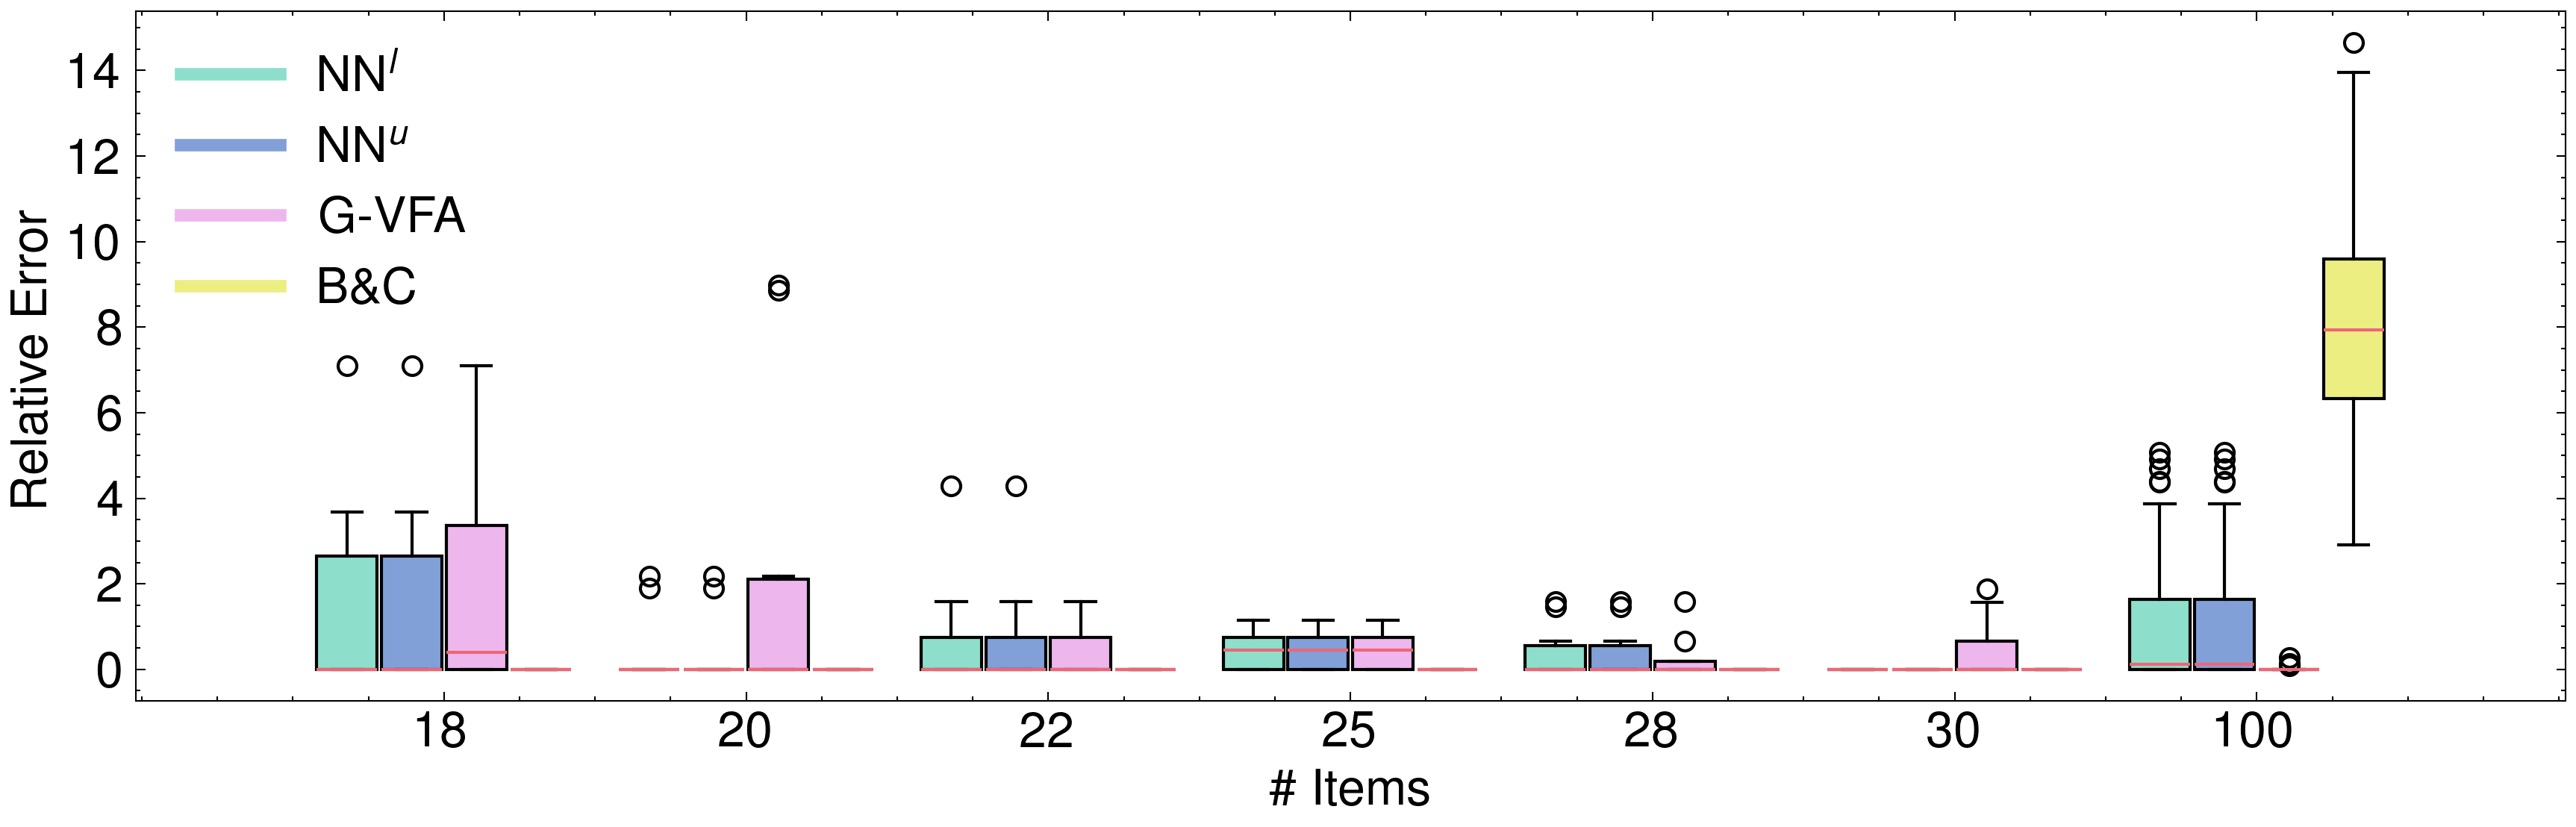

In [31]:
plot_for_k_ratio(relative_errors, 1/4)

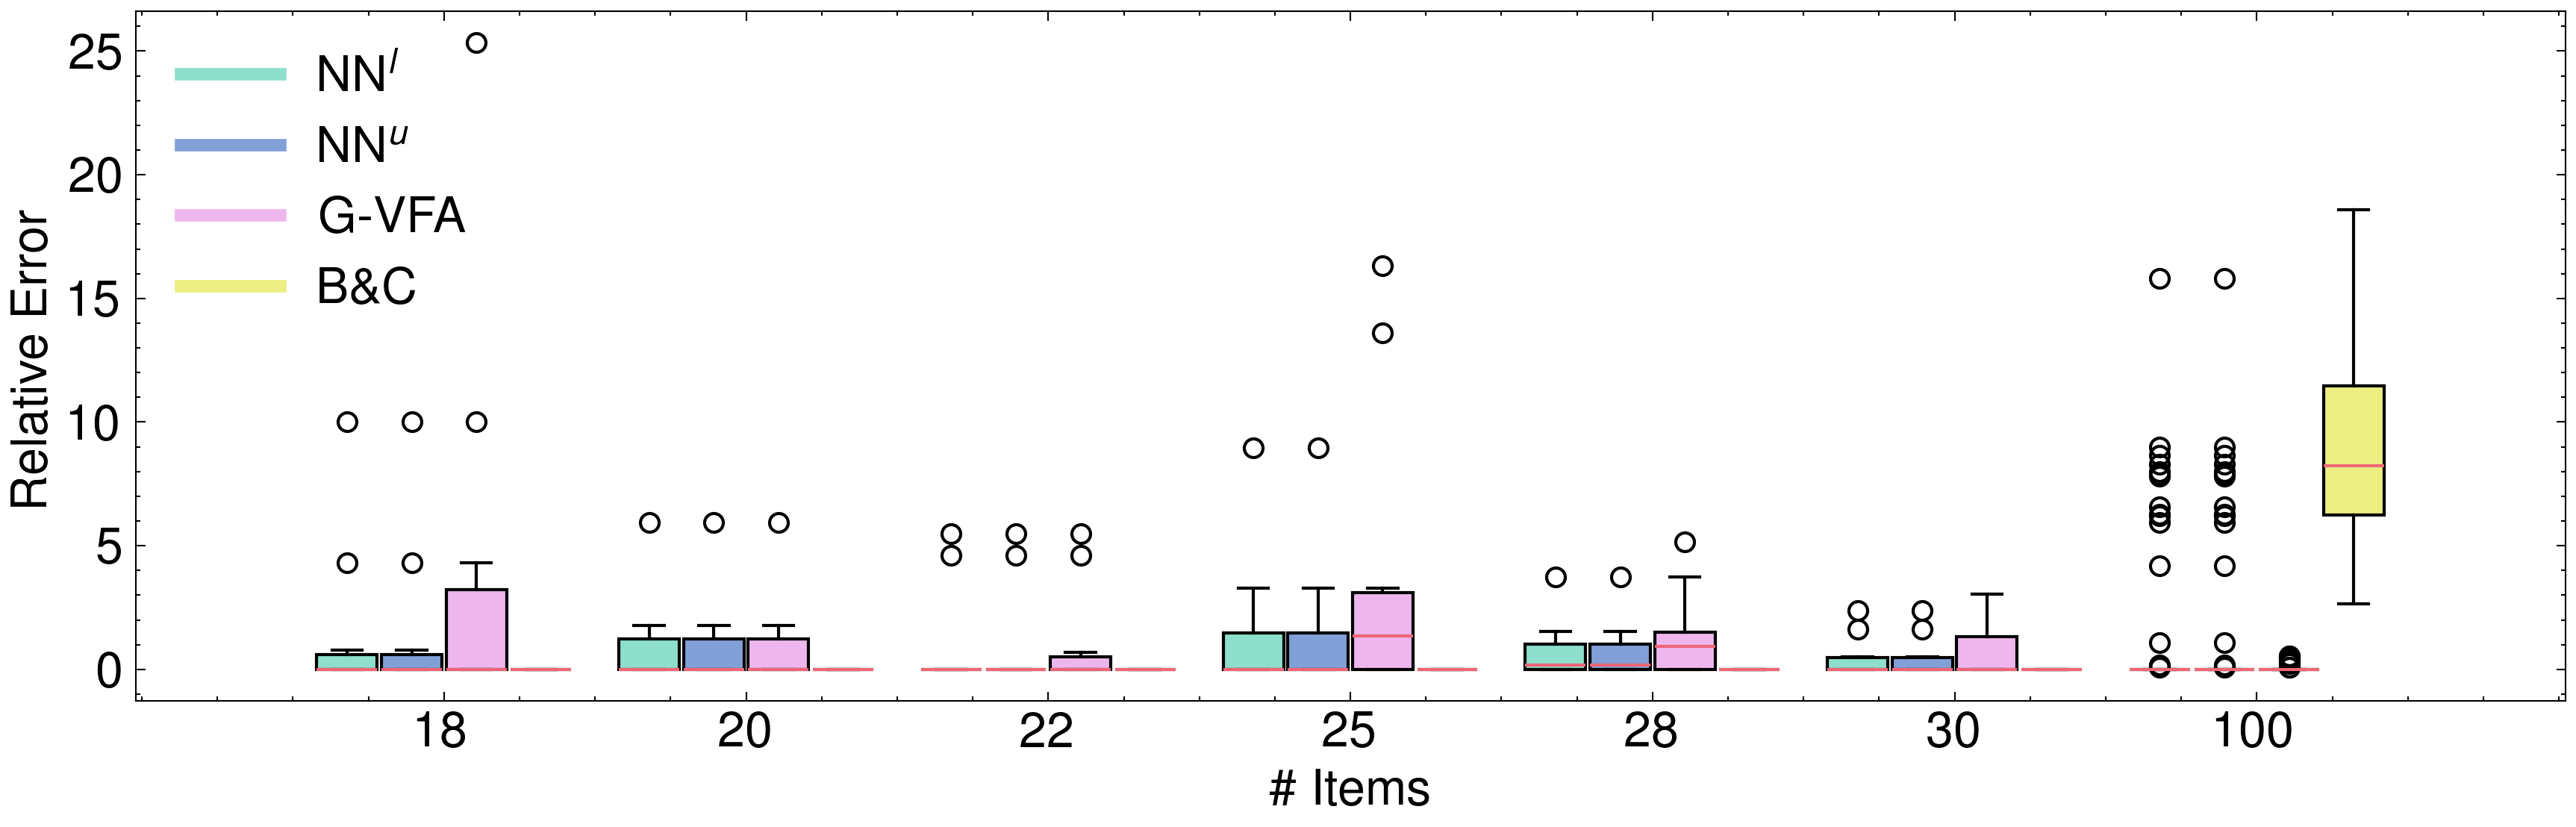

In [32]:
plot_for_k_ratio(relative_errors, 1/2)

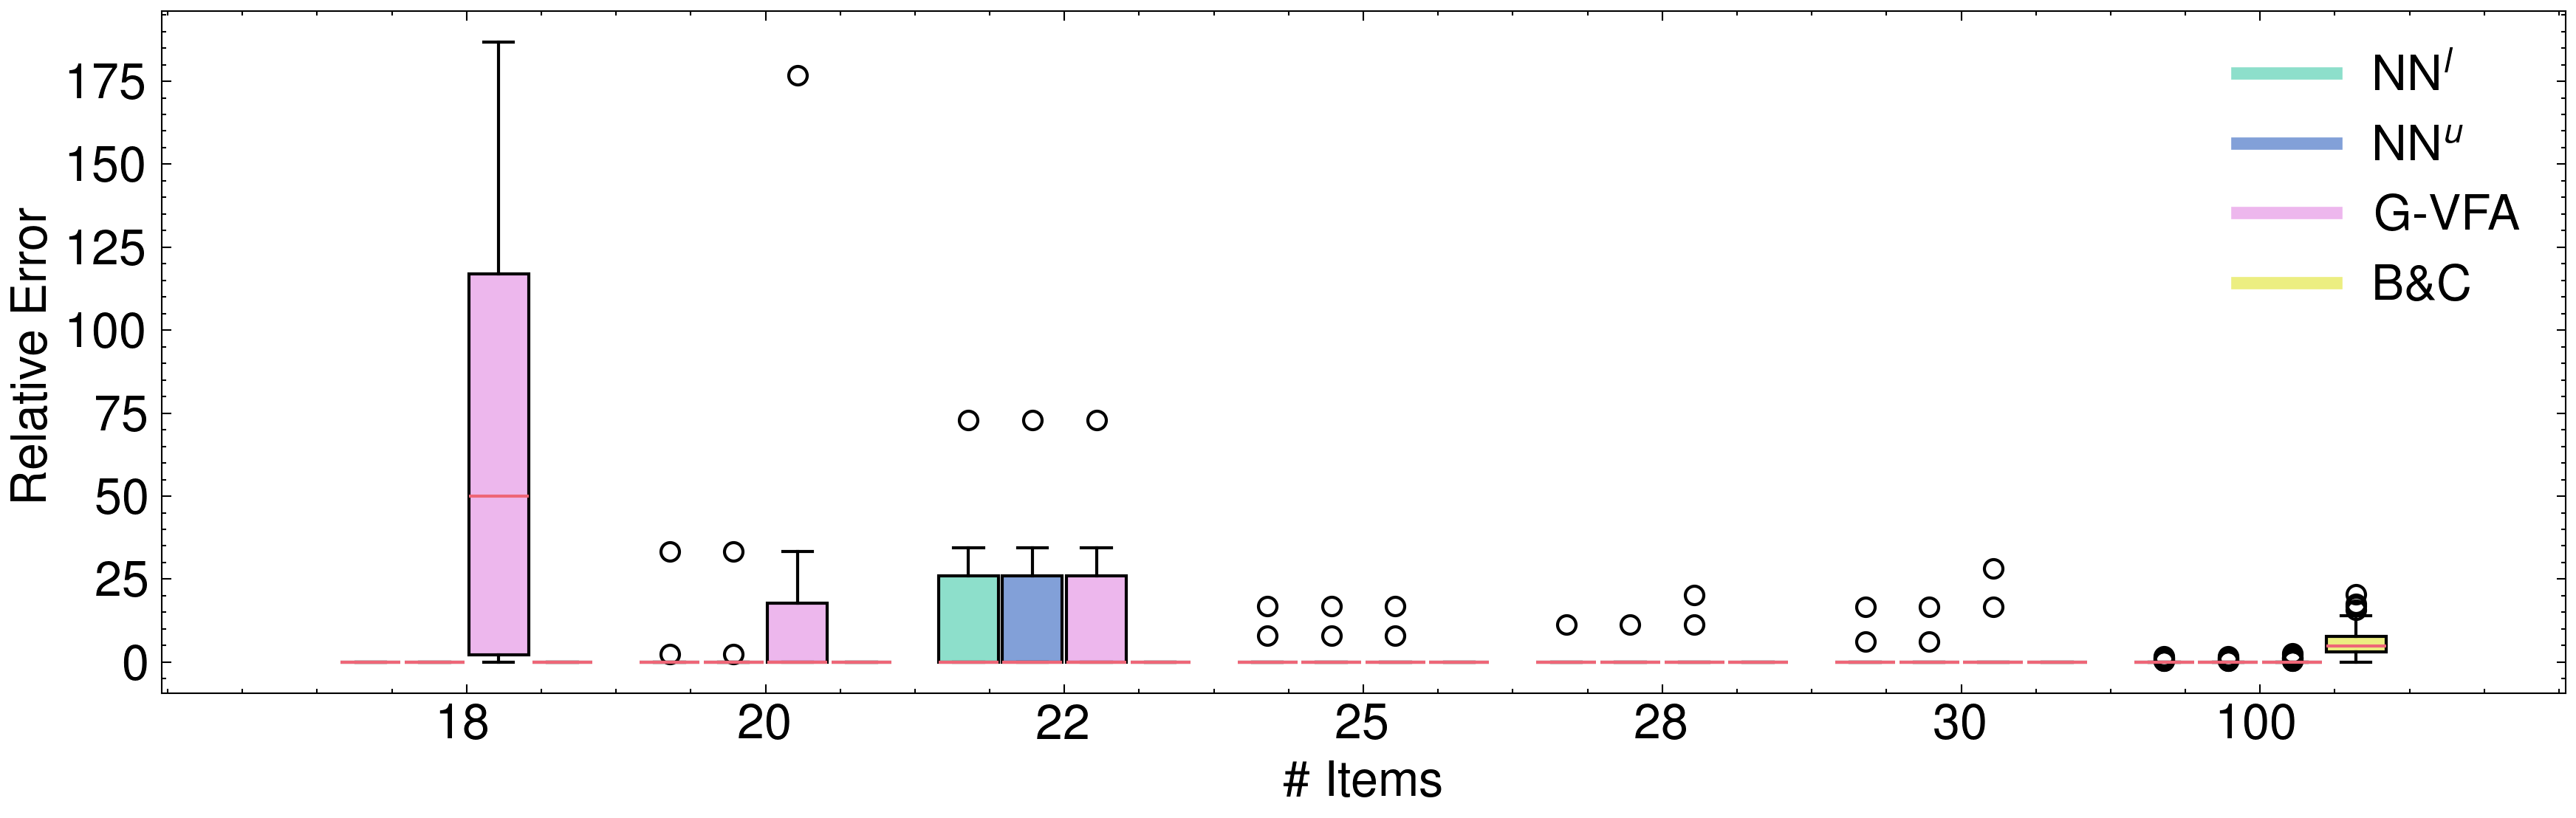

In [33]:
plot_for_k_ratio(relative_errors, 3/4)

# Appendix Lower-Level ML

In [34]:
# columns for table
cols = ['nn_l_obj', 'nn_d_obj', 'nn_n_obj', 
        'nn_l_mre', 'nn_d_mre', 'nn_n_mre', 
        'nn_l_time', 'nn_d_time', 'nn_n_time',
       ]

In [35]:
# indicies for table
indicies = []
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        id = f"{n} & {k}"
        indicies.append(id)

In [36]:
df = pd.DataFrame(index=indicies, columns=cols)

In [37]:
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        
        # results for ml slack at n,k
        nn_slack_res = nn_slack_results[n][k]
        nn_slack_times = list(map(lambda x: x['time'], nn_slack_res))
        nn_slack_objs = list(map(lambda x: x['follower_obj'], nn_slack_res))
        
        # results for ml dampening at n,k
        nn_dampening_res = nn_dampening_results[n][k]
        nn_dampening_times = list(map(lambda x: x['time'], nn_dampening_res))
        nn_dampening_objs = list(map(lambda x: x['follower_obj'], nn_dampening_res))
            
        # results for ml none (i.e., no constraint adjustment) at n,k
        nn_none_res = nn_none_results[n][k]
        nn_none_times = list(map(lambda x: x['time'], nn_none_res))
        nn_none_objs = list(map(lambda x: x['follower_obj'], nn_none_res))

        # best best known obj for each instance
        objs = np.array([nn_slack_objs, nn_dampening_objs, nn_none_objs])
        best_objs = list(np.min(objs, axis=0))

        # compute relative errors
        nn_slack_re = list(map(lambda x, y: 100 * (x-y)/y, nn_slack_objs, best_objs)) 
        nn_dampening_re = list(map(lambda x, y: 100 * (x-y)/y, nn_dampening_objs, best_objs)) 
        nn_none_re = list(map(lambda x, y: 100 * (x-y)/y, nn_none_objs, best_objs)) 

        
        
        # add results to dataframe
        id = f"{n} & {k}"
        df['nn_d_obj'][id] = np.mean(nn_dampening_objs)
        df['nn_l_obj'][id] = np.mean(nn_slack_objs)
        df['nn_n_obj'][id] = np.mean(nn_none_objs)

        df['nn_d_mre'][id] = np.mean(nn_dampening_re)
        df['nn_l_mre'][id] = np.mean(nn_slack_re)
        df['nn_n_mre'][id] = np.mean(nn_none_re) 
        
        df['nn_d_time'][id] = np.mean(nn_dampening_times)
        df['nn_l_time'][id] = np.mean(nn_slack_times)
        df['nn_n_time'][id] = np.mean(nn_none_times)


In [38]:
def latex_results_appendix_lower_level(df_):
    """ Generate Latex table for results.  """
    df = df_.copy()

    df = df.rename(columns={
        'nn_d_obj' : '\\mld',
        'nn_l_obj' : '\\mls',
        'nn_n_obj' : '\\mln',
 
        'nn_d_mre' : '\\mld\ ',
        'nn_l_mre' : '\\mls\ ',
        'nn_n_mre' : '\\mln\ ',

        'nn_d_time' : '\\mld\ \ ',
        'nn_l_time' : '\\mls\ \ ',
        'nn_n_time' : '\\mln\ \ ',
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_min(subset=['\\mld',     '\\mls',     '\\mln',], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mld\ ',   '\\mls\ ',   '\\mln\ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mld\ \ ', '\\mls\ \ ', '\\mln\ \ '], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{Knapsack results comparing \\mls{}, \\mld{}, and \\mln{}. '
    end_str += 'Each row averaged over 10 instances, except for $n=100$, which is average over 100 instances.  ' 
    end_str += 'All times in seconds.  }'
    end_str += '\\label{tab:kp_lower_appendix}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='cc|rrr|rrr|rrr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    row_id = f"$n$ & $k$"
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{3}{c|}{Objective}  &  \multicolumn{3}{c|}{Mean Relative Error (\%)}  & \multicolumn{3}{c}{Times} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.7\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [39]:
latex_results_appendix_lower_level(df)

\begin{table*}[h]\centering\resizebox{0.7\textwidth}{!}{
\begin{tabular}{cc|rrr|rrr|rrr}
\toprule
$n$ & $k$ & \multicolumn{3}{c|}{Objective}  &  \multicolumn{3}{c|}{Mean Relative Error (\%)}  & \multicolumn{3}{c}{Times} \\
 & \mls & \mld & \mln & \mls\  & \mld\  & \mln\  & \mls\ \  & \mld\ \  & \mln\ \  \\
\midrule
18 & 5 & \textbf{308.30} & 308.40 & 318.40 & \textbf{0.00} & 0.03 & 3.28 & \textbf{0.59} & 0.83 & 1.06 \\
18 & 9 & \textbf{145.60} & \textbf{145.60} & 152.90 & \textbf{0.00} & \textbf{0.00} & 6.70 & \textbf{0.59} & 1.21 & 0.81 \\
18 & 14 & \textbf{31.00} & 37.50 & 40.00 & \textbf{0.00} & 16.91 & 48.23 & \textbf{0.22} & 0.32 & 0.35 \\
20 & 5 & \textbf{390.30} & \textbf{390.30} & 413.90 & \textbf{0.00} & \textbf{0.00} & 6.48 & \textbf{0.62} & 0.79 & 1.38 \\
20 & 10 & \textbf{165.40} & \textbf{165.40} & 175.90 & \textbf{0.00} & \textbf{0.00} & 6.60 & \textbf{0.66} & 1.47 & 1.76 \\
20 & 15 & 33.40 & \textbf{32.50} & 55.70 & \textbf{3.33} & 14.29 & 100.91 & \textbf{0.32} & 0.38 &

## Appendix: Greedy

In [40]:
# load greedy results
data_dir_greedy = f'../data/kp_no_greedy/'
nn_no_greedy_slack_results = get_results(n_vals, k_ratios, data_dir_greedy, model_type, "slack", "lower")

In [41]:
# columns for table
cols = [
    'nn_lg_obj', 'nn_lng_obj',
    'nn_lg_mre', 'nn_lng_mre',
    'nn_lg_time', 'nn_lng_time',
]

In [42]:
# indicies for table
indicies = []
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        id = f"{n} & {k}"
        indicies.append(id)

In [43]:
df = pd.DataFrame(index=indicies, columns=cols)

In [44]:
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        
        # with greedy
        nn_slack_res = nn_slack_results[n][k]
        nn_slack_times = list(map(lambda x: x['time'], nn_slack_res))
        nn_slack_objs = list(map(lambda x: x['follower_obj'], nn_slack_res))

        # without greedy
        nn_slack_no_greedy_res = nn_no_greedy_slack_results[n][k]
        nn_slack_no_greedy_times = list(map(lambda x: x['time'], nn_slack_no_greedy_res))
        nn_slack_no_greedy_objs = list(map(lambda x: x['follower_obj'], nn_slack_no_greedy_res))
    
        # best best known obj for each instance
        objs = np.array([nn_slack_no_greedy_objs, nn_slack_objs])
        best_objs = list(np.min(objs, axis=0))

        # compute relative errors
        nn_slack_re = list(map(lambda x, y: 100 * (x-y)/y, nn_slack_objs, best_objs)) 
        nn_slack_no_greedy_re = list(map(lambda x, y: 100 * (x-y)/y, nn_slack_no_greedy_objs, best_objs)) 

        # add results to dataframe
        id =  f"{n} & {k}"
        df['nn_lg_obj'][id] = np.mean(nn_slack_objs)
        df['nn_lng_obj'][id] = np.mean(nn_slack_no_greedy_objs)

        df['nn_lg_mre'][id] = np.mean(nn_slack_re)
        df['nn_lng_mre'][id] = np.mean(nn_slack_no_greedy_re) 

        df['nn_lg_time'][id] = np.mean(nn_slack_times)
        df['nn_lng_time'][id] = np.mean(nn_slack_no_greedy_times)


In [45]:
def latex_greedy_appendix(df_):
    """ Generate Latex table for results.  """

    df = df_.copy()

    df = df.rename(columns={
        'nn_lg_obj' : '\\mls{} greedy',
        'nn_lng_obj' : '\\mls{} no greedy',
 
        'nn_lg_mre' : '\\mls{} greedy\ ',
        'nn_lng_mre' : '\\mls{} no greedy\ ',
        
        'nn_lg_time' : '\\mls{} greedy\ \ ',
        'nn_lng_time' : '\\mls{} no greedy\ \ ',
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_min(subset=['\\mls{} greedy', '\\mls{} no greedy'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls{} greedy\ ', '\\mls{} no greedy\ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls{} greedy\ \ ', '\\mls{} no greedy\ \ '], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{Knapsack results comparing \\mls{} with and without greedy-based features \\mld{}. '
    end_str += 'Each row averaged over 10 instances, except for $n=100$, which is average over 100 instances.  ' 
    end_str += 'All times in seconds.  }\n'
    end_str += '\\label{tab:kp_greedy_appendix}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='cc|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    row_id = f"$n$ & $k$"
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{2}{c|}{Objective}  &  \multicolumn{2}{c|}{Mean Relative Error (\%)}  & \multicolumn{2}{c}{Times} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.6\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [46]:
latex_greedy_appendix(df)

\begin{table*}[h]\centering\resizebox{0.6\textwidth}{!}{
\begin{tabular}{cc|rr|rr|rr}
\toprule
$n$ & $k$ & \multicolumn{2}{c|}{Objective}  &  \multicolumn{2}{c|}{Mean Relative Error (\%)}  & \multicolumn{2}{c}{Times} \\
 & \mls{} greedy & \mls{} no greedy & \mls{} greedy\  & \mls{} no greedy\  & \mls{} greedy\ \  & \mls{} no greedy\ \  \\
\midrule
18 & 5 & \textbf{308.30} & 314.90 & \textbf{0.85} & 2.93 & 0.59 & \textbf{0.06} \\
18 & 9 & \textbf{145.60} & 150.50 & \textbf{1.17} & 4.28 & 0.59 & \textbf{0.07} \\
18 & 14 & \textbf{31.00} & 41.60 & \textbf{0.00} & 55.04 & 0.22 & \textbf{0.05} \\
20 & 5 & \textbf{390.30} & 404.40 & \textbf{0.00} & 3.71 & 0.62 & \textbf{0.06} \\
20 & 10 & \textbf{165.40} & 172.00 & \textbf{0.55} & 4.06 & 0.66 & \textbf{0.05} \\
20 & 15 & \textbf{33.40} & 36.50 & \textbf{0.00} & 7.31 & 0.32 & \textbf{0.06} \\
22 & 6 & \textbf{385.50} & 390.60 & \textbf{0.59} & 1.88 & 0.19 & \textbf{0.07} \\
22 & 11 & \textbf{163.20} & 170.80 & \textbf{0.00} & 4.31 & 0.28 & \t

## Appendix: ISNN

In [47]:
n_vals = [18, 20, 22, 25, 28, 30]

In [48]:
# columns for table
cols = ['isnn_obj', 'nn_l_obj', 'nn_u_obj', 'g_obj', 's_obj',
        'isnn_mre', 'nn_l_mre', 'nn_u_mre', 'g_mre', 's_mre',
        'isnn_time', 'nn_l_time', 'nn_u_time', 'g_time', 's_time', 
        'isnn_to', 'nn_l_to', 'nn_u_to', 'g_to', 
        'isnn_at', 'nn_l_at', 'nn_u_at', 'g_at', 
       ]

In [49]:
# indicies for table
indicies = []
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        id = f"{n} & {k}"
        indicies.append(id)

In [50]:
avg = "\\multicolumn{2}{c|}{Average \\cite{tang2016class}}"
indicies.append(avg)

# more in depth gap storing
relative_errors = {
    'isnn' : {},
    'nn_l' : {},
    'nn_u': {},
    'greedy' : {},
    'exact' : {},
 }

for k_ratio in k_ratios:
    relative_errors['isnn'][k_ratio] = {}
    relative_errors['nn_l'][k_ratio] = {}
    relative_errors['nn_u'][k_ratio] = {}
    relative_errors['greedy'][k_ratio] = {}
    relative_errors['exact'][k_ratio] = {}

In [51]:
df = pd.DataFrame(index=indicies, columns=cols)

In [52]:
for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        
        # results for solver
        solver_res = solver_results[n][k]
        solver_times = list(map(lambda x: x['time'], solver_res))
        solver_objs = list(map(lambda x: x['follower_obj'], solver_res))

        # results for greedy
        greedy_res = greedy_results[n][k]
        greedy_times = list(map(lambda x: x['time'], greedy_res))
        greedy_objs = list(map(lambda x: x['obj'], greedy_res))

        # results for isnn
        isnn_res = isnn_results[n][k]
        isnn_times = list(map(lambda x: x['time'][0], isnn_res))
        isnn_objs = list(map(lambda x: x['blo_solve_res']['follower_obj'], isnn_res))
        
        # results for ml-s
        nn_slack_res = nn_slack_results[n][k]
        nn_slack_times = list(map(lambda x: x['time'], nn_slack_res))
        nn_slack_objs = list(map(lambda x: x['follower_obj'], nn_slack_res))
        
        # results for ml-u
        nn_upper_res = nn_upper_results[n][k]
        nn_upper_times = list(map(lambda x: x['time'], nn_upper_res))
        nn_upper_objs = list(map(lambda x: x['follower_obj'], nn_upper_res))

        # get time to results
        as_ratio = True
        isnn_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), isnn_objs, isnn_times, solver_res))
        greedy_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), greedy_objs, greedy_times, solver_res))
        nn_slack_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), nn_slack_objs, nn_slack_times, solver_res))
        nn_upper_time_to = list(map(lambda x, y, z: get_time_to_obj(x, y, z, as_ratio=as_ratio), nn_upper_objs, nn_upper_times, solver_res))

        # get obj at time
        as_re = True
        solver_at_isnn_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), isnn_objs, isnn_times, solver_res))
        solver_at_nn_slack_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), nn_slack_objs, nn_slack_times, solver_res))
        solver_at_nn_upper_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), nn_upper_objs, nn_upper_times, solver_res))
        solver_at_greedy_time = list(map(lambda x, y, z: get_obj_at_ml_time(x, y, z, as_re=as_re), greedy_objs, greedy_times, solver_res))

        # best best known obj for each instance
        objs = np.array([solver_objs, greedy_objs, nn_slack_objs, nn_upper_objs, isnn_objs])
        best_objs = list(np.min(objs, axis=0))

        # compute relative errors
        solver_re = list(map(lambda x, y: 100 * (x-y)/y, solver_objs, best_objs)) 
        greedy_re = list(map(lambda x, y: 100 * (x-y)/y, greedy_objs, best_objs)) 
        nn_slack_re = list(map(lambda x, y: 100 * (x-y)/y, nn_slack_objs, best_objs)) 
        nn_upper_re = list(map(lambda x, y: 100 * (x-y)/y, nn_upper_objs, best_objs)) 
        isnn_re = list(map(lambda x, y: 100 * (x-y)/y, isnn_objs, best_objs)) 

        #id = (n,k)
        id = f"{n} & {k}"
        
        # add results to dataframe
        df['isnn_obj'][id] = np.mean(isnn_objs)
        df['nn_l_obj'][id] = np.mean(nn_slack_objs)
        df['nn_u_obj'][id] = np.mean(nn_upper_objs)
        df['g_obj'][id] = np.mean(greedy_objs)
        df['s_obj'][id] = np.mean(solver_objs)

        df['isnn_mre'][id] = np.mean(isnn_re)
        df['nn_l_mre'][id] = np.mean(nn_slack_re)
        df['nn_u_mre'][id] = np.mean(nn_upper_re)
        df['g_mre'][id] = np.mean(greedy_re)
        df['s_mre'][id] = np.mean(solver_re)

        df['isnn_time'][id] = np.mean(isnn_times)
        df['nn_l_time'][id] = np.mean(nn_slack_times)
        df['nn_u_time'][id] = np.mean(nn_upper_times)
        df['g_time'][id] = np.mean(greedy_times)
        df['s_time'][id] = np.mean(solver_times)

        df['isnn_to'][id] = get_time_to_str(isnn_time_to)
        df['nn_l_to'][id] = get_time_to_str(nn_slack_time_to)
        df['nn_u_to'][id] = get_time_to_str(nn_upper_time_to)
        df['g_to'][id] = get_time_to_str(greedy_time_to)

        df['isnn_at'][id] = get_time_to_str(solver_at_isnn_time)
        df['nn_l_at'][id] = get_time_to_str(solver_at_nn_slack_time)
        df['nn_u_at'][id] = get_time_to_str(solver_at_nn_upper_time)
        df['g_at'][id] = get_time_to_str(solver_at_greedy_time)

        relative_errors['isnn'][k_ratio][n] = isnn_re
        relative_errors['nn_l'][k_ratio][n] = nn_slack_re
        relative_errors['nn_u'][k_ratio][n] = nn_upper_re
        relative_errors['greedy'][k_ratio][n] = greedy_re
        relative_errors['exact'][k_ratio][n] = solver_re

In [53]:
isnn_time = []
nn_l_time = []
nn_u_time = []
greedy_time = []
solver_time = []

isnn_mre = []
nn_l_mre = []
nn_u_mre = []
greedy_mre = []
solver_mre = []

for n in n_vals:
    for k_ratio in k_ratios:
        k = int(np.ceil(n * k_ratio))
        
        solver_res = solver_results[n][k]
        solver_times = list(map(lambda x: x['time'], solver_res))
        solver_objs = list(map(lambda x: x['follower_obj'], solver_res))

        # results for greedy
        greedy_res = greedy_results[n][k]
        greedy_times = list(map(lambda x: x['time'], greedy_res))
        greedy_objs = list(map(lambda x: x['obj'], greedy_res))

        # results for isnn
        isnn_res = isnn_results[n][k]
        isnn_times = list(map(lambda x: x['time'][0], isnn_res))
        isnn_objs = list(map(lambda x: x['blo_solve_res']['follower_obj'], isnn_res))
        
        # results for ml-s
        nn_slack_res = nn_slack_results[n][k]
        nn_slack_times = list(map(lambda x: x['time'], nn_slack_res))
        nn_slack_objs = list(map(lambda x: x['follower_obj'], nn_slack_res))
        
        # results for ml-u
        nn_upper_res = nn_upper_results[n][k]
        nn_upper_times = list(map(lambda x: x['time'], nn_upper_res))
        nn_upper_objs = list(map(lambda x: x['follower_obj'], nn_upper_res))

        # best best known obj for each instance
        objs = np.array([solver_objs, greedy_objs, nn_slack_objs, nn_upper_objs, isnn_objs])
        best_objs = list(np.min(objs, axis=0))

        # compute relative errors
        solver_re = list(map(lambda x, y: 100 * (x-y)/y, solver_objs, best_objs)) 
        greedy_re = list(map(lambda x, y: 100 * (x-y)/y, greedy_objs, best_objs)) 
        nn_slack_re = list(map(lambda x, y: 100 * (x-y)/y, nn_slack_objs, best_objs)) 
        nn_upper_re = list(map(lambda x, y: 100 * (x-y)/y, nn_upper_objs, best_objs)) 
        isnn_re = list(map(lambda x, y: 100 * (x-y)/y, isnn_objs, best_objs)) 

        isnn_time += isnn_times
        nn_l_time += nn_slack_times
        nn_u_time += nn_upper_times
        greedy_time += greedy_times
        solver_time += solver_times

        isnn_mre += isnn_re
        nn_l_mre += nn_slack_re
        nn_u_mre += nn_upper_re
        greedy_mre += greedy_re
        solver_mre += solver_re

In [54]:
df['isnn_mre'][avg] = np.mean(isnn_mre)
df['nn_l_mre'][avg] = np.mean(nn_l_mre)
df['nn_u_mre'][avg] = np.mean(nn_u_mre)
df['g_mre'][avg] = np.mean(greedy_mre)
df['s_mre'][avg] = np.mean(solver_mre)

df['isnn_time'][avg] = np.mean(isnn_time)
df['nn_l_time'][avg] = np.mean(nn_l_time)
df['nn_u_time'][avg] = np.mean(nn_u_time)
df['g_time'][avg] = np.mean(greedy_time)
df['s_time'][avg] = np.mean(solver_time)

In [55]:
def latex_isnn(df_):
    """ Generate Latex table for results.  """
    df = df_.copy()

    df = df.drop('isnn_obj', axis=1)
    df = df.drop('nn_l_obj', axis=1)
    df = df.drop('nn_u_obj', axis=1)
    df = df.drop('g_obj', axis=1)
    df = df.drop('s_obj', axis=1)

    df = df.drop('isnn_to', axis=1)
    df = df.drop('nn_l_to', axis=1)
    df = df.drop('nn_u_to', axis=1)
    df = df.drop('g_to', axis=1)

    df = df.drop('isnn_at', axis=1)
    df = df.drop('nn_l_at', axis=1)
    df = df.drop('nn_u_at', axis=1)
    df = df.drop('g_at', axis=1)

    col_order = [
        'isnn_mre', 'isnn_time',
        'nn_l_mre', 'nn_l_time',
        'nn_u_mre', 'nn_u_time', 
        'g_mre', 'g_time', 
        's_mre', 's_time',
    ]

    df = df[col_order]

    df = df.rename(columns={
        'isnn_mre' : 'MRE-i',
        'nn_l_mre' : 'MRE',
        'nn_u_mre' : 'MRE\ ',
        'g_mre'    : 'MRE\ \ ',
        's_mre'    : 'MRE\ \ \ ',

        'isnn_time' : 'Time-i',
        'nn_l_time' : 'Time',
        'nn_u_time' : 'Time\ ',
        'g_time'    : 'Time\ \ ',
        's_time'    : 'Time\ \ \ ',
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_min(subset=['MRE-i', 'MRE',  'MRE\ ',  'MRE\ \ ',  'MRE\ \ \ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['Time-i', 'Time', 'Time\ ', 'Time\ \ ', 'Time\ \ \ '], props='textbf:--rwrap;', axis=1)
    
    # caption
    end_str = '}\n\\caption{Knapsack Results:'
    end_str += 'Each row averaged over 10 instances.  ' 
    end_str += '\\mls{} and \\mlu{} specify the lower- and upper-level approximations respectively.  '
    end_str += 'All times in seconds.  }\n'
    end_str += '\\label{tab:kp_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='cc|rr|rr|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')
    
    latex_str2 = (latex_str.splitlines())
    row_id = "$n$ & $k$"
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{2}{c|}{\\issn} & \multicolumn{2}{c|}{\\mls}  & \multicolumn{2}{c|}{\\mlu} & \multicolumn{2}{c}{\\greedy} & \multicolumn{2}{c}{\\solver} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.6\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [56]:
latex_isnn(df)

\begin{table*}[h]\centering\resizebox{0.6\textwidth}{!}{
\begin{tabular}{cc|rr|rr|rr|rr|rr}
\toprule
$n$ & $k$ & \multicolumn{2}{c|}{\issn} & \multicolumn{2}{c|}{\mls}  & \multicolumn{2}{c|}{\mlu} & \multicolumn{2}{c}{\greedy} & \multicolumn{2}{c}{\solver} \\
 & MRE-i & Time-i & MRE & Time & MRE\  & Time\  & MRE\ \  & Time\ \  & MRE\ \ \  & Time\ \ \  \\
\midrule
18 & 5 & 10.50 & 254.35 & 1.48 & 0.59 & 1.48 & 0.34 & 1.82 & \textbf{0.14} & \textbf{0.00} & 9.55 \\
18 & 9 & 46.50 & 227.49 & 1.51 & 0.59 & 1.51 & 0.43 & 3.97 & \textbf{0.22} & \textbf{0.00} & 5.81 \\
18 & 14 & 302.10 & 217.62 & \textbf{0.00} & 0.22 & \textbf{0.00} & 0.17 & 64.22 & \textbf{0.03} & \textbf{0.00} & 0.39 \\
20 & 5 & 8.56 & 262.01 & 0.41 & 0.62 & 0.41 & 0.45 & 2.19 & \textbf{0.25} & \textbf{0.00} & 23.18 \\
20 & 10 & 54.07 & 236.74 & 0.99 & 0.66 & 0.99 & 0.58 & 0.99 & \textbf{0.36} & \textbf{0.00} & 10.27 \\
20 & 15 & 447.29 & 229.41 & 3.57 & 0.32 & 3.57 & 0.19 & 23.39 & \textbf{0.02} & \textbf{0.00} & 0.94 \\
22

# Data Collection + Training Time

In [57]:
class A():
    pass

In [58]:
args = A()
args.n = n
model_type = "inst_encoder"

In [59]:
ml_times = {}
tr_times = {}


for n in n_vals:

    args.problem = f"kp_{n}"
    get_path = factory_get_path(args)
    cfg = getattr(blo_params, args.problem)
    cfg.data_path = f'../data/'

    # get data collection time
    fp_data = get_path(cfg.data_path, cfg, "ml_data")
    with open(fp_data, 'rb') as pf:
        ml_dataset = pkl.load(pf)

    ml_times[n] = ml_dataset['total_time']

    # solving time
    approx_type = "both"

    fp_nn_res = get_path(cfg.data_path, cfg, f"nn_res_{model_type}_{approx_type}", suffix="pkl")
    with open(fp_nn_res, 'rb') as pf:
        nn_res = pkl.load(pf)

    tr_times[n] = nn_res['train_time']

In [60]:
ml_times

{18: 142.0896863937378,
 20: 172.65060782432556,
 22: 141.61772465705872,
 25: 170.3072154521942,
 28: 142.3465461730957,
 30: 168.91935896873474}

In [61]:
tr_times

{18: 2576.4315025806427,
 20: 4714.885327339172,
 22: 2346.209715127945,
 25: 4007.758370399475,
 28: 2684.808289051056,
 30: 1835.2712910175323}